In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder, LeaveOneOutEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import shap

Load data

In [4]:
df_file = pd.read_csv('sum_customer_data.csv')

df_file.describe()

,contacts,interactions,daysSinceLastInteraction,averageOfferValue,offerClosed,offerHitRate,daysSinceLastOfferClosed
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2.000000,16.000000,100.406500,10003.208795,9.058000,0.452375,88.131500
std,1.004741,4.034866,64.445814,234.972259,3.072516,0.114300,57.101563
min,1.000000,4.000000,33.000000,9036.680000,1.000000,0.070000,33.000000
25%,1.000000,13.000000,53.000000,9851.797500,7.000000,0.380000,48.000000
50%,2.000000,16.000000,79.000000,10000.790000,9.000000,0.450000,70.000000
75%,3.000000,19.000000,133.000000,10155.605000,11.000000,0.530000,109.000000
max,7.000000,32.000000,473.000000,10822.470000,19.000000,0.870000,568.000000


Separate the feature and target

In [5]:
X = df_file.drop(columns=['customerClassification'], errors='ignore')
y = df_file['customerClassification']
X_feature_names = X.columns

Check if feature target is unique

In [7]:
np.unique(y)

array(['A', 'B', 'C'], dtype=object)

Define the numerical and categorical features for normalization

In [8]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

Since the cardinality of the categorical features is highly variable, we need to split them into low / mod / high for applying right Encoder for normalize the data

In [9]:
low_cat_features = [i for i in categorical_features if X[i].nunique() <= 10]
mod_cat_features = [i for i in categorical_features if 10 < X[i].nunique() <= 50]
high_cat_features = [i for i in categorical_features if X[i].nunique() > 50]

Apply the preprocessor for normalizing and Encode the data

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  
        ('low_card_cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), low_cat_features), 
        ('mod_card_cat', LeaveOneOutEncoder(), mod_cat_features),
        ('high_card_cat', TargetEncoder(), high_cat_features) 
    ]
)

Encode the target feature seperately 

In [11]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

Split the data for training and testing 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Fit the preprocessor with trained and tested data

In [13]:
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

Create the model 

In [14]:
rf = RandomForestClassifier(random_state=42)

Check Hyperparameters with GridSearchCV

In [15]:
p_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf, param_grid=p_grid, cv=5, n_jobs=1, verbose=2)
grid_search.fit(X_train_processed, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2

c:\Users\elijoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

Print-out the output of the Gridsearch

In [16]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 1.0


Create predictions based on the tested model

In [17]:
A_model = grid_search.best_estimator_
y_train_pred = A_model.predict(X_train_processed)
y_pred = A_model.predict(X_test_processed)

Check the accuracy_score of best model

In [24]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Test Accuracy: 0.9275


Print out the classification_report based on the best model

In [25]:
print("\nClassification Report For Best Model:")
print(classification_report(y_test, y_pred, zero_division=0))


Classification Report For Best Model:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       114
           1       0.85      1.00      0.92       160
           2       1.00      0.84      0.91       126

    accuracy                           0.93       400
   macro avg       0.95      0.92      0.93       400
weighted avg       0.94      0.93      0.93       400



Create a new model with the parameters from the "best model" but changing the max_depth=10

In [26]:
rf = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42)
rf.fit(X_train_processed, y_train)


RandomForestClassifier(max_depth=10, random_state=42)

Predict and evaluate on the training and test data

In [27]:
y_train_pred = rf.predict(X_train_processed)
train_accuracy = accuracy_score(y_train, y_train_pred)
y_pred = rf.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Test Accuracy: 0.9425


Print out the classification_report based on the new model


In [28]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       114
           1       0.87      1.00      0.93       160
           2       1.00      0.90      0.95       126

    accuracy                           0.94       400
   macro avg       0.96      0.94      0.94       400
weighted avg       0.95      0.94      0.94       400



Plot the actual vs predicted

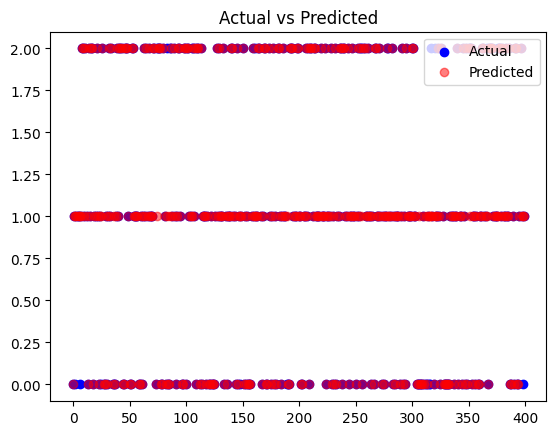

In [30]:
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted', alpha=0.5)
plt.legend()
plt.title("Actual vs Predicted")
plt.show()

Check feature importance from the model

Define the feature names preprocessor

In [34]:
low_cat_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(low_cat_features)
numerical_feature_names = numerical_features
mod_cat_feature_names = mod_cat_features 
high_cat_feature_names = high_cat_features

X_feature_names = (list(numerical_feature_names) + 
                 list(low_cat_feature_names) + 
                 list(mod_cat_feature_names) + 
                 list(high_cat_feature_names))

print(f"Length of feature_names: {len(X_feature_names)}")
print(f"Shape of X_train_processed: {X_train_processed.shape}")
print(f"Shape of X_test_processed: {X_test_processed.shape}")

Length of feature_names: 21
Shape of X_train_processed: (1600, 21)
Shape of X_test_processed: (400, 21)


In [35]:
rf_feature_importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature' : X_feature_names, 'Importance' : rf_feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importances:")
print(feature_importance_df)


Random Forest Feature Importances:
                                        Feature  Importance
4                                   offerClosed    0.364154
17                                      company    0.233701
20                          interactionSubjects    0.185453
18                                         city    0.162228
5                                  offerHitRate    0.032674
19                                        roles    0.007136
16                                        state    0.004550
3                             averageOfferValue    0.002820
6                      daysSinceLastOfferClosed    0.002350
2                      daysSinceLastInteraction    0.001463
1                                  interactions    0.001112
0                                      contacts    0.000814
7                                    size_Large    0.000362
11  industry_Automotive R&D and Testing Centers    0.000249
10     industry_Automobile Manufacturers (OEMs)    0.000177
14  

Create visualization with SHAP

In [37]:
t_explainer = shap.TreeExplainer(rf)
shap_values = t_explainer.shap_values(X_test_processed)

Visualize the output of classification 0 with summary_plot and dependence_plot

Customer classification - 0


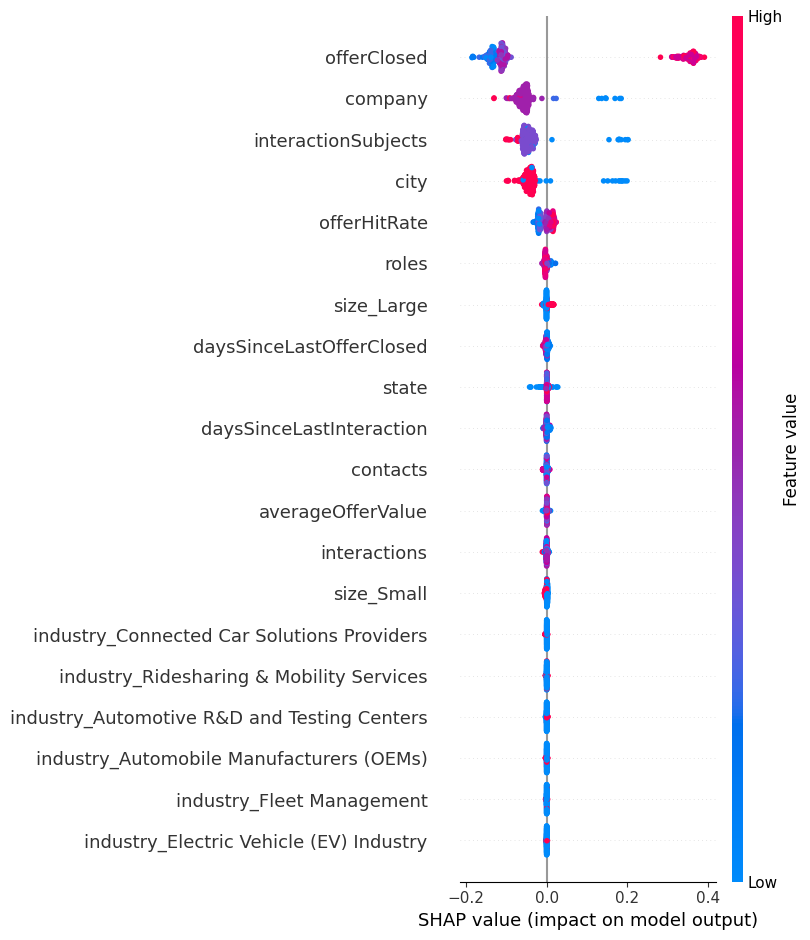

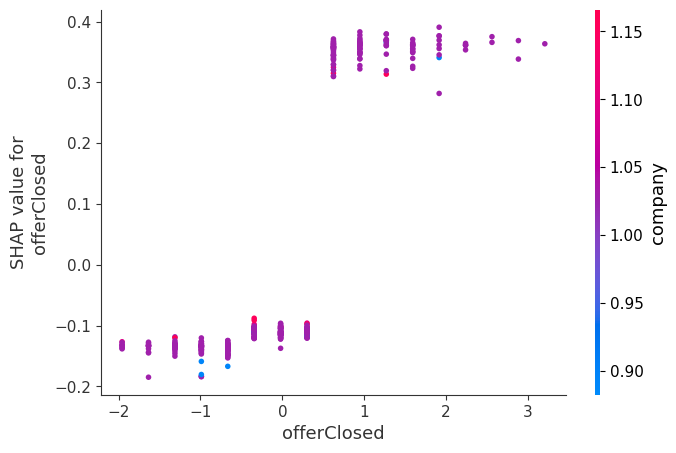

In [38]:
print("Customer classification - 0")
shap_values_class_0 = shap_values[:, :, 0]
shap.summary_plot(shap_values_class_0, X_test_processed, feature_names=X_feature_names)  
most_important_feature = feature_importance_df.iloc[0]['Feature']
shap.dependence_plot(most_important_feature, shap_values_class_0, X_test_processed, feature_names=X_feature_names)

Visualize the output of classification 0 with force_plot

In [39]:
shap.initjs()
shap.force_plot(t_explainer.expected_value[0], shap_values[0], X_test_processed)